<a href="https://colab.research.google.com/github/Luana-lrb/LIPAI_Python/blob/main/onboarding/src/semana_8/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explorando o dataset Fashion-MNIST para classificação**

Importando bibliotecas necessárias:

In [21]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader,random_split
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

Configurando para usar GPU:

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Treinando em:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Treinando em: cuda
GPU: Tesla T4


Transform e datasets:

In [23]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

root_path = '/home/storopoli/Downloads'  # Está funcionando assim
train_dataset_full = torchvision.datasets.FashionMNIST(root=root_path, train=True, transform=trans, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(root=root_path, train=False, transform=trans)


Dividindo em treino e validação

In [24]:
train_size = int(0.8 * len(train_dataset_full))   # 80% treino
val_size   = len(train_dataset_full) - train_size # 20% validação
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

In [25]:
batch_size = 32
num_workers = 0  # ajuste conforme sua máquina; no Windows usar 0 às vezes
pin_memory = True if device.type == "cuda" else False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=pin_memory)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=pin_memory)



In [26]:
train_dataset_full

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/storopoli/Downloads
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [27]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /home/storopoli/Downloads
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

O modelo, conforme o utilizado no outro dataset:

In [28]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [29]:
model = ConvNet().to(device)
print(model)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parâmetros treináveis:", count_parameters(model))

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)
Parâmetros treináveis: 3199106


In [30]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 10
optimizer = Adam(model.parameters(), lr=learning_rate)
torch.backends.cudnn.benchmark = True if device.type == "cuda" else False

Treinamento

In [31]:
#Listas para o histórico
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

#Salvar o melhor modelo
best_val_acc = 0.0
best_model_path = 'best_mnist_cnn_model.pth'


total_step = len(train_loader)

for epoch in range(epochs):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # forward + loss
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # backward + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # métricas do step
        total = labels.size(0)
        predicted = outputs.argmax(dim=1)
        correct = (predicted == labels).sum().item()
        acc = 100 * correct / total

        running_loss += loss.item()
        running_correct += correct
        running_total += total

        if (i + 1) % 100 == 0:
            print(f"Época [{epoch+1}/{epochs}], "
                  f"Step [{i+1}/{total_step}], "
                  f"Loss: {loss.item():.4f}, "
                  f"Acc: {acc:.2f}%")

    # ===== Calcular Métricas =====
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = 100 * running_correct / running_total

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc)

    # ===== Validação ao fim da época =====
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    #scheduler.step(val_loss)

    #===== Salvando o melhor modelo =====
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'train_loss': train_epoch_loss,
            'val_loss': val_loss
        }, best_model_path)

    print(f"===== Fim da Época {epoch+1} =====")
    print(f"Validação -> Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    print("==========================")


Época [1/10], Step [100/1500], Loss: 0.4137, Acc: 84.38%
Época [1/10], Step [200/1500], Loss: 0.4817, Acc: 84.38%
Época [1/10], Step [300/1500], Loss: 0.3844, Acc: 81.25%
Época [1/10], Step [400/1500], Loss: 0.4062, Acc: 84.38%
Época [1/10], Step [500/1500], Loss: 0.2255, Acc: 87.50%
Época [1/10], Step [600/1500], Loss: 0.3994, Acc: 87.50%
Época [1/10], Step [700/1500], Loss: 0.3382, Acc: 84.38%
Época [1/10], Step [800/1500], Loss: 0.2836, Acc: 87.50%
Época [1/10], Step [900/1500], Loss: 0.1979, Acc: 93.75%
Época [1/10], Step [1000/1500], Loss: 0.2326, Acc: 87.50%
Época [1/10], Step [1100/1500], Loss: 0.5053, Acc: 78.12%
Época [1/10], Step [1200/1500], Loss: 0.7433, Acc: 71.88%
Época [1/10], Step [1300/1500], Loss: 0.3043, Acc: 87.50%
Época [1/10], Step [1400/1500], Loss: 0.5013, Acc: 87.50%
Época [1/10], Step [1500/1500], Loss: 0.1288, Acc: 96.88%
===== Fim da Época 1 =====
Validação -> Loss: 0.2989, Acc: 89.07%
Época [2/10], Step [100/1500], Loss: 0.0490, Acc: 100.00%
Época [2/10], S

Avaliação Total

In [32]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Acurácia do Modelo em {total} imagens de teste: {100 * correct / total:.3f}%")

Acurácia do Modelo em 10000 imagens de teste: 91.290%


Grafico de perda e da acurácia:

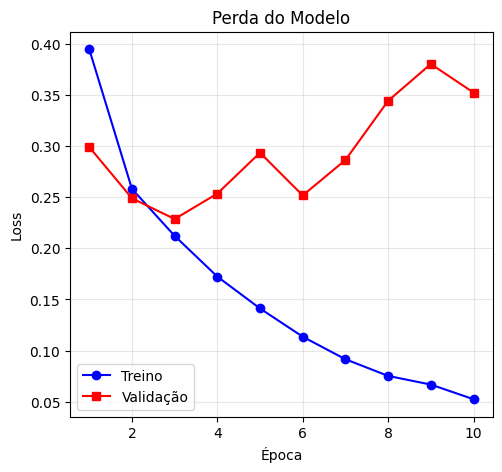

In [33]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, 'b-', label='Treino', marker='o')
plt.plot(epochs_range, val_losses, 'r-', label='Validação', marker='s')
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

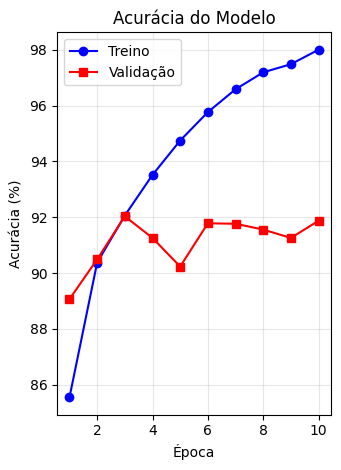

In [34]:

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, 'b-', label='Treino', marker='o')
plt.plot(epochs_range, val_accuracies, 'r-', label='Validação', marker='s')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()